In [1]:
# Average morphed cells for PXN and TOMM20 to illustrate the difference between GFP and SEG

In [2]:
!pwd
!date

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureMorphingExt
Sun Jun 26 20:35:32 PDT 2022


In [3]:
import os
import sys
import importlib
import concurrent
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage, writers
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting
from cvapipe_analysis.steps.compute_features.compute_features_tools import FeatureCalculator
from vtk import util
sys.path.insert(1, '../tools')
import common

In [4]:
# Controller form cvapipe_analysis
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
control = controller.Controller(general.load_config_file(path_config))
print(control.get_staging())

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance


In [5]:
device = io.LocalStagingIO(control)
df = device.load_step_manifest("preprocessing")
print(df.shape)

(202847, 1290)


In [6]:
importlib.reload(shapespace)
space = shapespace.ShapeSpace(control)
space.execute(df)

In [7]:
df_sphere = space.get_cells_inside_ndsphere_of_radius()
df_sphere = df_sphere.set_index("structure")

In [24]:
importlib.reload(common)

<module 'common' from '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureMorphingExt/../tools/common.py'>

In [25]:
# Running the parameterization here because we don't have pre-computed PILRs for GFP, only SEG.
def parameterize_this_cell(irow):

    index, row = irow

    #Use redirect_path form common <<<<<<<<<<<<<<<<<<
    
#     subpath_old = "projects/cvapipe_analysis"
#     subpath_new = "datasets/hpisc_single_cell/variance"
#     # redirecting the path to seg images bc some files are corrupted (fixme before resubmission)
#     row.crop_seg = row.crop_seg.replace(subpath_old, subpath_new)
    
    producer = io.DataProducer(control)
    row = common.redirect_single_cell_path(row)
    producer.set_row(row)
    producer.load_single_cell_data()
    producer.align_data()
    
    nuc = (producer.data_aligned[3]>0).astype(np.uint8)
    mem = (producer.data_aligned[4]>0).astype(np.uint8)
    
    (coeffs_mem, _), (mem, mesh_mem, _, centroid_mem) = shparam.get_shcoeffs(
        image=mem,
        lmax=control.get_lmax(),
        sigma=control.get_sigma(),
        alignment_2d=False
    )

    (coeffs_nuc, _), (nuc, mesh_nuc, _, centroid_nuc) = shparam.get_shcoeffs(
        image=nuc,
        lmax=control.get_lmax(),
        sigma=control.get_sigma(),
        alignment_2d=False
    )
    
    nuc = nuc.astype(np.uint8)
    mem = mem.astype(np.uint8)
    instance = np.stack([nuc, mem, producer.data_aligned[2], producer.data_aligned[-1]], axis=0).astype(np.uint16)

    niso = control.get_number_of_interpolating_points()
    coords_param, coeffs_centroid = cytoparam.parameterize_image_coordinates(
        seg_mem=mem,
        seg_nuc=nuc,
        lmax=control.get_lmax(),
        nisos=[niso, niso]
    )

    coeffs_mem, centroid_mem, coeffs_nuc, centroid_nuc = coeffs_centroid

    rep = cytoparam.parameterization_from_shcoeffs(
        coeffs_mem=coeffs_mem,
        centroid_mem=centroid_mem,
        coeffs_nuc=coeffs_nuc,
        centroid_nuc=centroid_nuc,
        nisos=[niso, niso],
        images_to_probe=[("gfp", instance[-2]), ("seg", instance[-1])]
    ).data.squeeze()
    
    return rep

In [26]:
# Parameterize cells of all structures we want in the figure
reps = {}
genes = ["PXN", "TOMM20"]
for gene in genes:
    irows = [irow for irow in df.loc[df_sphere.loc[gene].CellIds].iterrows()]
    with concurrent.futures.ProcessPoolExecutor(control.get_ncores()) as executor:
        reps[gene] = np.array(list(tqdm(executor.map(parameterize_this_cell, irows), total=len(irows)))).mean(axis=0)

  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/4158 [00:00<?, ?it/s]

/home/matheus.viana/anaconda3/envs/lab-variance/lib/python3.8/site-packages/aicsshparam/shparam.py:127: UserWarning: Mesh centroid seems to fall outside the object. This indicates        the mesh may not be a manifold suitable for spherical harmonics        parameterization.
  warnings.warn(
/home/matheus.viana/anaconda3/envs/lab-variance/lib/python3.8/site-packages/aicsshparam/shparam.py:127: UserWarning: Mesh centroid seems to fall outside the object. This indicates        the mesh may not be a manifold suitable for spherical harmonics        parameterization.
  warnings.warn(


### Create the domain to morph aggregations into

In [27]:
variables = control.get_variables_values_for_aggregation()
df_agg = shapespace.ShapeSpaceBasic(control).get_aggregated_df(variables).drop(columns=["structure"])
df_agg = df_agg.drop_duplicates().reset_index(drop=True)
df_agg = df_agg.loc[df_agg.mpId==control.get_center_map_point_index()].head(1)
df_agg

,shape_mode,mpId,aggtype,alias
4,NUC_MEM_PC1,5,avg,STR


In [28]:
device.row = df_agg.loc[df_agg.index[0]]
nisos = control.get_number_of_interpolating_points()
inner_alias = control.get_inner_most_alias_to_parameterize()
inner_mesh = device.read_map_point_mesh(inner_alias)
outer_alias = control.get_outer_most_alias_to_parameterize()
outer_mesh = device.read_map_point_mesh(outer_alias)
domain, origin = cytoparam.voxelize_meshes([outer_mesh, inner_mesh])
coords_param, coeffs_centroid = cytoparam.parameterize_image_coordinates(
    seg_mem=(domain>0).astype(np.uint8),
    seg_nuc=(domain>1).astype(np.uint8),
    lmax=control.get_lmax(), nisos=[nisos, nisos]
)
coeffs_mem, centroid_mem, coeffs_nuc, centroid_nuc = coeffs_centroid
coords_param += np.array(centroid_nuc).reshape(3, 1, 1)-np.array(centroid_mem).reshape(3, 1, 1)

In [29]:
domain_nuc = (255*(domain>1)).astype(np.uint8)
domain_mem = (255*(domain>0)).astype(np.uint8)

### Morphing PILRs into mean shape

In [30]:
morphs = {}
for gene, rep in reps.items():
    for ch, chname in enumerate(["gfp", "seg"]):
        morphed = cytoparam.morph_representation_on_shape(
            img=domain,
            param_img_coords=coords_param,
            representation=rep[ch]
        )
        morphs[f"{gene}_{chname}"] = np.stack([domain_nuc, domain_mem, morphed], axis=0)

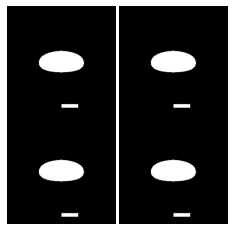

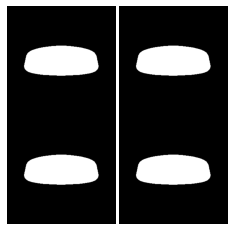

In [31]:
mode = {
    "nuc":"center_nuc",
    "mem":"center_nuc",
    "gfp":"center_nuc"
}
args = {"gridspec_kw": {"hspace": 0, "wspace": 0}, "sharex": True, "sharey": True}
for alias in ["nuc", "mem"]:
    fig, axes = plt.subplots(len(genes), 2, figsize=(2*2,2*len(genes)), **args)
    for gid, (gene, axs) in enumerate(zip(genes, axes)):
        for imtype, ax in zip(["gfp", "seg"], axs):
            ax.axis("off")
            instance = morphs[f"{gene}_{imtype}"]
            proj = common.Projector(instance)
            proj.set_projection_mode(ax="y", mode=mode)
            proj.project_on(alias=alias, ax=ax, scale_bar={"pixel_size":0.108, "length":5})
    plt.savefig(f"FigureMorphingExt3_gfp_seg_{alias}_y.png", dpi=150)
    plt.show()

Image shape: (300, 300, 300), slices used: (145,148,149)
Image shape: (300, 300, 300), slices used: (145,148,149)
Image shape: (300, 300, 300), slices used: (145,148,149)
GFP min/max: 406.660 / 414.153
Image shape: (300, 300, 300), slices used: (145,148,149)
Image shape: (300, 300, 300), slices used: (145,148,149)
Image shape: (300, 300, 300), slices used: (145,148,149)
vmin/vmax values already set...
Image shape: (300, 300, 300), slices used: (145,148,149)
Image shape: (300, 300, 300), slices used: (145,148,149)
Image shape: (300, 300, 300), slices used: (145,148,149)
GFP min/max: 416.561 / 465.339
Image shape: (300, 300, 300), slices used: (145,148,149)
Image shape: (300, 300, 300), slices used: (145,148,149)
Image shape: (300, 300, 300), slices used: (145,148,149)
vmin/vmax values already set...


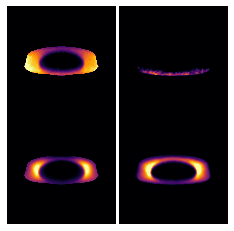

In [36]:
mode = {
    "nuc":"center_nuc",
    "mem":"center_nuc",
    "gfp":"center_nuc"
}
args = {"gridspec_kw": {"hspace": 0, "wspace": 0}, "sharex": True, "sharey": True}
for alias in ["gfp"]:
    fig, axes = plt.subplots(len(genes), 2, figsize=(2*2,2*len(genes)), **args)
    for gid, (gene, axs) in enumerate(zip(genes, axes)):
        for imtype, ax in zip(["gfp", "seg"], axs):
            ax.axis("off")
            instance = morphs[f"{gene}_{imtype}"]
            proj = common.Projector(instance)
            proj.set_verbose_on()
            proj.set_projection_mode(ax="y", mode=mode)
            if imtype == "seg":
                vmin, vmax = control.get_optimal_avgseg_contrast(gene)
                proj.set_vmin_vmax_gfp_values(vmin, vmax)
            else:
                proj.set_gfp_percentiles([20, 98], local=True)
            proj.project_on(alias=alias, ax=ax)
    plt.savefig(f"FigureMorphingExt3_gfp_seg_gfp_y.png", dpi=150)
    plt.show()

In [38]:
common.now("complete")

complete 2022-06-27 08:49:58
